# 03. Deep Learning Training Workflows

In this notebook, we will implement a simple Logistic Regression model using a standard deep learning training workflow in PyTorch.

In [1]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 1. Dataset: Digits dataset (scikit-learn)

We are going to use a digits data set. Each $x$ is an 8x8 matrix representing a hand-written digits, and the $y$ is which of the 10 digits it represented.

**Note**: This is *not* MNIST.

In [2]:
raw_data = datasets.load_digits()
print(raw_data.keys())

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [3]:
print(raw_data.data.shape)
print(raw_data.target.shape)

(1797, 64)
(1797,)


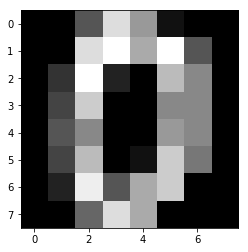

In [4]:
plt.imshow(raw_data.data[0].reshape(8, 8), cmap="gray")

## 2. Data Processing

First, we're going to split our data into train/val/test sets.

In [5]:
x_train, x_test, y_train, y_test = \
    train_test_split(raw_data.data, raw_data.target, test_size=0.2)
x_train, x_val, y_train, y_val = \
    train_test_split(x_train, y_train, test_size=0.2)

In [6]:
print(x_train.shape, x_val.shape, x_test.shape)

(1149, 64) (288, 64) (360, 64)


Before we proceed - two things about deep learning training workflows.

Unlike in the case of regressions (as before), we often cannot fit all the data into memory--particularly when training on GPUs, which often have less memory. Hence, we often train the models iteratively in **batches** (see: *minibatch gradient descent*).

Because we do gradient descent, we often also go over the data multiple times--in multiple **epochs**. We need to specify how many epochs to train for (later, you will learn other ways to step epochs early, or potentially not use epochs at all).

Here, we can easily fit all the data into memory, but we will pretend we cannot, and set our batch-size per gradient descent step to 32--so we're training on 32 instances per step.

In [7]:
BATCH_SIZE = 32
N_EPOCHS = 1000

Now, we are doing to subclass PyTorch's `Dataset` class. A Dataset class can be used to represent any kind of data. Importantly, you need to implement `__getitem__` and `__len__` methods. 

`__getitem__` in particular has a fixed signature, where given a numerical index, it returns the corresponding data for that instance. 

That is all you need to do to define the Dataset. PyTorch handles the rest in terms of converting to Tensors and batching - in `DataLoader`s.

In [8]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        assert len(x) == len(y)
        self.length = len(x)
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.length

We will create a data set for our train/val/test sets.

In [9]:
train_dataset = MyDataset(x_train, y_train)
val_dataset = MyDataset(x_val, y_val)
test_dataset = MyDataset(x_test, y_test)

Next, we will create a DataLoader for each data set. Note that we often want to shuffle our training data when we iterate over it, but not necessarily the validation and test sets.

In [10]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
)

## 3. Logistic Regression Model

We copy our model from the `logistic_regression` notebook.

In [11]:
class LogisticRegressionPyTorch(nn.Module):
    def __init__(self, n_in, n_out):
        """
        n_in: Number of features
        n_out: Number of output classes
        """
        super().__init__()
        self.linear = nn.Linear(n_in, n_out)
        self.init_weights()
        
    def forward(self, x):
        """
        x: Input data [N, k]
        ---
        Returns: log probabilities of each class [N, c]
        """
        logit = self.linear(x)
        return F.log_softmax(logit, dim=1)
    
    def init_weights(self):
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.uniform_(self.linear.bias)

## 4. Workflow

We will create 3 functions here:

1. A training method
2. An evaluation method
3. A method for computing accuracy

In both `do_train` and `do_eval`, we iterate over our provided DataLoader, and carry out the forward pass. Note that `x` and `y` are already neatly batched into the correct batch size and converted to Tensors.

Note that `do_train` and `do_eval` do have some overlap--but are also quite different. (See if you can spot all the differences.) Most importantly, we need to perform backpropagation in `do_train`, and in `do_eval` we want to record the outputs. It is possible to combine the two, but the function can get quite ugly--this is up to your personal taste.

*Make sure you understand every line of these methods.*

In [12]:
def do_train(model, dataloader, criterion, optimizer):
    model.train()
    loss_val = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = model(x.float())
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
        # Accurately compute loss, because of different batch size
        loss_val += loss.item() * len(x) / len(dataloader.dataset)
    return loss_val

def do_eval(model, dataloader, criterion):
    model.eval()
    loss_val = 0
    y_ls = []
    y_hat_ls = []
    with torch.no_grad():
        for x, y in dataloader:
            y_hat = model(x.float())
            loss = criterion(y_hat, y)
            # Accurately compute loss, because of different batch size
            loss_val += loss.item() * len(x) / len(dataloader.dataset)
            y_hat_ls.append(y_hat)
            y_ls.append(y)
    optimizer.zero_grad()
    return loss_val, torch.cat(y_hat_ls, dim=0), torch.cat(y_ls, dim=0)

def acc(model, dataloader, criterion):
    _, pred, true = do_eval(
        model=model, 
        dataloader=dataloader,
        criterion=criterion,
    )
    return (torch.exp(pred).max(1)[1] == true).float().mean().item()

We create our model, criterion and optimizer. We also want to record our training and validation losses over time.

In [13]:
train_loss_history = []
val_loss_history = []
model = LogisticRegressionPyTorch(
    n_in=raw_data.data.shape[1], 
    n_out=len(raw_data.target_names),
)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Here is the core of our training - we train, and also compute validation loss at each epoch.

Note: In some code bases you will often see the core training loop have all sorts of logic here (e.g. batching, data conversion, loss computation, logging, etc). I recommend you refactor those to separate functions/methods, and keep your core loop as clean as possible.

## 5. Experiments & Results

Frist, let's train the model:

In [14]:
# Pro-tip: Make your core loop CLEAN
for epoch in tqdm.trange(N_EPOCHS):
    train_loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_dataloader,
        optimizer=optimizer,
    )
    val_loss, val_pred, val_true = do_eval(
        model=model, 
        criterion=criterion,
        dataloader=val_dataloader,
    )
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

100%|██████████| 1000/1000 [00:19<00:00, 50.12it/s]


Let's do some inspections and plot our training and validation loss!

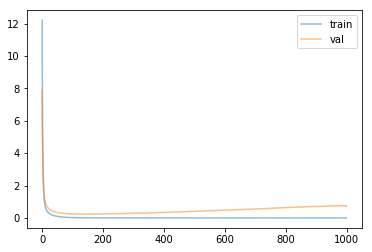

In [15]:
loss_history_df = pd.DataFrame({
    "train": train_loss_history,
    "val": val_loss_history,
})
loss_history_df.plot(alpha=0.5)

Compute the training, validation and test accuracies:

In [16]:
acc(model, train_dataloader, criterion)

1.0

In [17]:
acc(model, val_dataloader, criterion)

0.9513888955116272

In [18]:
acc(model, test_dataloader, criterion)

0.9611111283302307

(my in-class note)

### For training on GPU:
1. both model and training data need to be on GPU:
    `x, y = x.to(device), y.to(device)`
2. the computed y_hat is on GPU, if you need to to further computation on cpu, fetch the data first